In [1]:
# ISYS2407 Information Systems Solutions & Design

# Assignment 3

# Exploratory Data Analysis

#### Student name:

#### Student number:

# 1. Import libraries

In [2]:
# Import the library for pickling
# Library needed for counting categorical values
import collections

import joblib

# Import the plotting libraries
import matplotlib.pyplot as plt
import numpy as np

# Also need pandas here
import pandas as pd

%matplotlib inline
import seaborn as sns

# Import the model library
from sklearn.linear_model import LogisticRegression

# Import the libraries for computing the metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

# Library for performing grid search
# Library for splitting the data into train and test sets
from sklearn.model_selection import GridSearchCV, train_test_split

# Libary needed for onehot encoder
# Library for replacing labels with numbers
# Library to scale values
from sklearn.preprocessing import (
    LabelBinarizer,
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)

# Just use pandas get_dummies which is a lot easier to use

# 2. Load the cleaned data

#### Pickled file must exist in your folder

In [3]:
# Load the pickled file
personalLoan_df = joblib.load('personalLoan-cleaned.pkl')  

# Check
personalLoan_df.head()
personalLoan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786 entries, 0 to 3785
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         3786 non-null   int64  
 1   age                 3786 non-null   float64
 2   yrs_experience      3786 non-null   float64
 3   family_size         3786 non-null   float64
 4   education_level     3786 non-null   int64  
 5   income              3786 non-null   float64
 6   mortgage_amt        3786 non-null   int64  
 7   credit_card_acct    3786 non-null   int64  
 8   credit_card_spend   3786 non-null   float64
 9   share_trading_acct  3786 non-null   int64  
 10  fixed_deposit_acct  3786 non-null   int64  
 11  online_acct         3786 non-null   int64  
 12  personal_loan       3786 non-null   int64  
dtypes: float64(5), int64(8)
memory usage: 384.6 KB


# 3. Split the data into training and testing set

In [4]:
# Store the features in variable X (uppercase as there are multiple features)

# Features are variables that affect the target/label
# So, it's all the columns excluding the target column
# However, you may also use a subset of features previously identified as best features
# You might want to experiment with both the full set and the best features
feature_cols = [
    "education_level",
    "fixed_deposit_acct",
    "credit_card_spend",
    "mortgage_amt"
]



X = personalLoan_df[feature_cols]
# print('X:\n', X)

# Store the labels/target in variable y (lower case as its a single value)
y = personalLoan_df["personal_loan"]
# print('y:\n', y)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # keep 20% for testing
    random_state=12,  # pass an int for reproducible rtesult
)

# 4. Data Transformations to improve modelling performance

Should be performed after the data has been split into training and testing sets to prevent information leakage (train-test contamination)

## 4.1 Scale the columns with continuous values

In [5]:
# 1. Select the columns to scale
# Make sure they are continuous columns as scaling is only for continuous values
# Better list all the columns and comment out the ones you don't need
columns_to_scale = [
    "education_level",
    "fixed_deposit_acct",
    "credit_card_spend",
    "mortgage_amt"
]

# 2. Make copy of the training and testing sets fix the issue below
# Warning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
X_train = X_train.copy()
X_test = X_test.copy()

# 3. Instantiate a scaler
scaler = StandardScaler()

# 4. Fit the scaler on the training column and transform the training and testing columns
# Use a loop to scale all the required columns
for col in columns_to_scale:
    # print(col)
    # First fit the scaler to the column in the training data
    # Must reshape the numpy array returned b the scaler from 1D to 2D
    scaler.fit(X_train[col].values.reshape(-1, 1))
    # Then transform both the training and testing sets
    X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

# Check
print(X_train.shape, X_test.shape)

(3028, 4) (758, 4)


In [6]:
# Check again
X_train.head()

,education_level,fixed_deposit_acct,credit_card_spend,mortgage_amt
1322,-1.322237,-0.296706,-0.440689,0.009895
1635,1.062357,-0.296706,-0.440689,2.586095
142,-0.129940,-0.296706,-0.440689,-0.784528
3024,1.062357,-0.296706,-0.440689,-0.784528
36,-1.322237,-0.296706,-0.440689,1.383111


In [7]:
# Check again
X_test.head()

,education_level,fixed_deposit_acct,credit_card_spend,mortgage_amt
565,1.062357,-0.296706,-0.440689,0.282268
2584,1.062357,-0.296706,-0.440689,-0.784528
2784,1.062357,-0.296706,-0.370060,1.371763
691,1.062357,-0.296706,-0.440689,-0.784528
2544,-1.322237,3.370339,-0.440689,0.963202


# 5. Modelling

## 5.1 Initial/baseline model

### 5.1.1 Fit initial model

In [8]:
# Import the model library
from sklearn.neighbors import KNeighborsClassifier

# Instantiate model and fit on training data
knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

# Predict using test data
y_pred = knn_model.predict(X_test)

# Quick check
print(y_pred[:5])

[0 0 0 0 1]


### 5.1.1 Evaluate model

In [9]:
# Compute performance metrics of the baseline model
classification_accuracy = accuracy_score(y_test, y_pred)
print(f"classification_accuracy: {classification_accuracy}")
print(f"Is this a good classifier?")

classification_accuracy: 0.8614775725593667
Is this a good classifier?


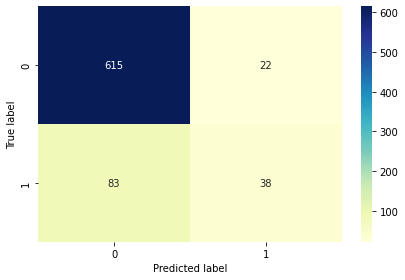

In [10]:
cf_matrix = confusion_matrix(y_test, y_pred)
# Visualise the confusion matrix as a Seaborn Heatmap
sns.heatmap(cf_matrix, annot=True, fmt="d", yticklabels=True, cmap="YlGnBu")

plt.ylabel("True label")
plt.xlabel("Predicted label")

# If you want to save the graph to disk
plt.tight_layout()  # automatically adjusts subplot to fit in the figure area
plt.savefig("confusion-matrix-initial.png", dpi=300)  # dpi=300 is print quality

In [11]:
recall = recall_score(y_test, y_pred)
print(f"recall: {recall}")

recall: 0.3140495867768595


In [12]:
precision = precision_score(y_test, y_pred)
print(f"precision: {precision}")

precision: 0.6333333333333333


In [13]:
f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1}")

F1 score: 0.4198895027624309


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       637
           1       0.63      0.31      0.42       121

    accuracy                           0.86       758
   macro avg       0.76      0.64      0.67       758
weighted avg       0.84      0.86      0.84       758



AUC: 0.64


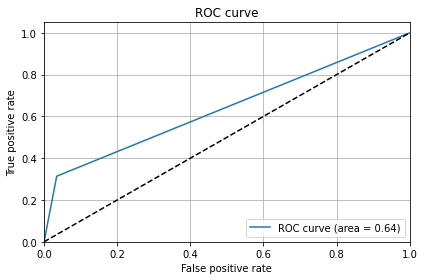

In [15]:
# Call function roc_curve() to get the false positive rates (fpr) and true positive rates
# Need to pass the list of actual and predicted classes as parameters to the function
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# print(fpr)
# print(tpr)

# Call the auc() function to calculate the area under the curve
# Need to pass the false positive rates (fpr) and true positive rates as parameters to the function
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:0.2f}")  # float 2 places of decimal

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid()
# plt.show()

# If you want to save the graph to disk
plt.tight_layout()  # automatically adjusts subplot to fit in the figure area
plt.savefig("roc-curve-initial.png", dpi=300)  # dpi=300 is print quality

## 5.2 Improved model

### 5.2.1 Use grid search to find best hyperameters

In [16]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# List of relevant params
#     n_neighbors:int, default=5
#     weights: {‘uniform’, ‘distance’} or callable, default=’uniform’
#     algorithm: {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’

param_grid = [
    {"n_neighbors": range(1, 50)},
    {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
]

# Instantiate a grid search object and fit it to the training data
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, param_grid, verbose=0, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_}, score: {grid.best_score_:0.2f}")

Best params: {'n_neighbors': 19}, score: 0.49


### 5.2.2 Fit improved model

In [17]:
# Instantiate model and fit on training data
# Instantiate model and fit on training data
knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

# Predict using test data
y_pred = knn_model.predict(X_test)

# Quick check
print(y_pred[:25])

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### 5.2.3 Evaluate  improved model

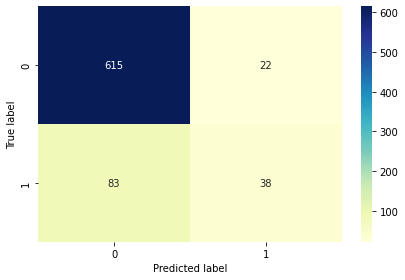

In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)
# Visualise the confusion matrix as a Seaborn Heatmap
sns.heatmap(cf_matrix, annot=True, fmt="d", yticklabels=True, cmap="YlGnBu")

plt.ylabel("True label")
plt.xlabel("Predicted label")

# If you want to save the graph to disk
plt.tight_layout()  # automatically adjusts subplot to fit in the figure area
plt.savefig("confusion-matrix-initial.png", dpi=300)  # dpi=300 is print quality

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       637
           1       0.63      0.31      0.42       121

    accuracy                           0.86       758
   macro avg       0.76      0.64      0.67       758
weighted avg       0.84      0.86      0.84       758



AUC: 0.64


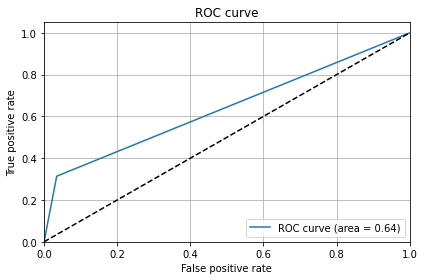

In [20]:
# Call function roc_curve() to get the false positive rates (fpr) and true positive rates
# Need to pass the list of actual and predicted classes as parameters to the function
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# print(fpr)
# print(tpr)

# Call the auc() function to calculate the area under the curve
# Need to pass the false positive rates (fpr) and true positive rates as parameters to the function
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:0.2f}")  # float 2 places of decimal

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid()
# plt.show()

# If you want to save the graph to disk
plt.tight_layout()  # automatically adjusts subplot to fit in the figure area
plt.savefig("roc-curve-initial.png", dpi=300)  # dpi=300 is print quality